In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

load_dotenv()

# llm = ChatOpenAI(
#                     temperature=0,
#                     max_tokens=4096,
#                     presence_penalty=1.2,
#                     model='deepseek-chat',
#                     openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
#                     openai_api_base="https://api.deepseek.com/v1",
#                 )

model = ChatOllama(
                    temperature=0,
                    num_predict=4096,
                    repeat_penalty=1.2,
                    model="llama3.2:3b"
                )

# Define the graph with persistence

In [3]:
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict


# subgraph


class SubgraphState(TypedDict):
    foo: str  # note that this key is shared with the parent graph state
    bar: str


def subgraph_node_1(state: SubgraphState):
    return {"bar": "bar"}


def subgraph_node_2(state: SubgraphState):
    # note that this node is using a state key ('bar') that is only available in the subgraph
    # and is sending update on the shared state key ('foo')
    return {"foo": state["foo"] + state["bar"]}


subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


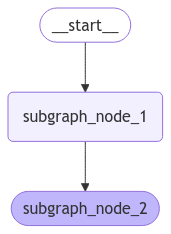

In [4]:
from IPython.display import Image, display

display(Image(subgraph.get_graph().draw_mermaid_png()))

In [ ]:
# parent graph


class State(TypedDict):
    foo: str

def node_1(state: State):
    return {"foo": "hi! " + state["foo"]}


builder = StateGraph(State)
builder.add_node("node_1", node_1)
# note that we're adding the compiled subgraph as a node to the parent graph
builder.add_node("node_2", subgraph)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")

checkpointer = MemorySaver()
# You must only pass checkpointer when compiling the parent graph.
# LangGraph will automatically propagate the checkpointer to the child subgraphs.
graph = builder.compile(checkpointer=checkpointer)

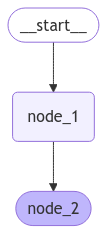

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Verify persistence works

In [8]:
config = {"configurable": {"thread_id": "1"}}

In [9]:
for _, chunk in graph.stream({"foo": "foo"}, config, subgraphs=True):
    print(chunk)

{'node_1': {'foo': 'hi! foo'}}
{'subgraph_node_1': {'bar': 'bar'}}
{'subgraph_node_2': {'foo': 'hi! foobar'}}
{'node_2': {'foo': 'hi! foobar'}}


In [10]:
"""
To view the subgraph state, we need to do two things:

Find the most recent config value for the subgraph
Use graph.get_state() to retrieve that value for the most recent subgraph config.
"""

graph.get_state(config).values

{'foo': 'hi! foobar'}

In [11]:
state_with_subgraph = [
    s for s in graph.get_state_history(config) if s.next == ("node_2",)
][0]

In [12]:
subgraph_config = state_with_subgraph.tasks[0].state
subgraph_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': 'node_2:e14bbcd3-5c46-46ea-46b8-9282088fdbb5'}}

In [13]:
graph.get_state(subgraph_config).values

{'foo': 'hi! foobar', 'bar': 'bar'}